# Prelim

This notebook explains how to handle filtering and analysis when multiple samples need to be analyzed together. We will use the multiome data of the T-cell depleted bone marrow in the [SEACells](https://www.google.com/search?q=seacells+biorxiv&oq=seacells+biorxi&aqs=chrome.0.0i512j69i57.3474j0j7&sourceid=chrome&ie=UTF-8) manuscript. The data was generated using two 10X channels.

The initial part of the notebook shows how to handle multiple samples. After combinig the two samples, the notebook follows the same flow of the multiome single-cell sample notebook. 

Data available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/`

In [1]:
# Download the example data
!aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/ multi-sample-multiome/

## Setup

Change thes parameters to fit your project

In [2]:
# specify the path to each cell ranger .h5 file per sample
input_dirs = {
    # sample name : input directory
    "rep1": "multi-sample-multiome/rep1/filtered_feature_bc_matrix.h5",
    "rep2": "multi-sample-multiome/rep2/filtered_feature_bc_matrix.h5",
}

# Set this to the directory the results should we written to
output_dir = "multi-sample-multiome"

# Imports

In [3]:
import os
import pwd
import pandas as pd
import numpy as np

In [4]:
import anndata
import scanpy as sc
import palantir
import harmony
import scrublet as scr

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["image.cmap"] = "Spectral_r"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.right"] = "off"

# Utility functions

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res["T"] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(
        delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1] : seq[i]])
        for i in range(1, len(seq))
    )
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return csr_matrix(imputed_data)

# Load data

In [8]:
# RNA and ATAC data

rna_ad_dict, atac_ad_dict = dict(), dict()
for sample_name, in_dir in input_dirs.items():
    print(f"Loading {in_dir} ...")
    temp_ad = sc.read_10x_h5(in_dir, gex_only=False)

    # Use a name which is indicative of the data
    temp_ad.obs_names = sample_name + "#" + temp_ad.obs_names

    temp_ad.obs["sample"] = sample_name
    temp_ad.var["gene_id"] = temp_ad.var["gene_ids"]
    del temp_ad.var["gene_ids"]
    temp_ad.var = temp_ad.var.set_index("gene_id")

    # RNA
    rna_ad_dict[sample_name] = temp_ad[
        :, temp_ad.var["feature_types"] == "Gene Expression"
    ].copy()

    directory, _ = os.path.split(in_dir)
    directory, _ = os.path.split(directory)
    feature_file = os.path.join(directory, "features.tsv.gz")
    features = pd.read_csv(feature_file, sep="\t", header=None, index_col=0)
    features.columns = ["gene_name", "feature_types", "chromosome", "start", "end"]
    del features["feature_types"]
    features.index.name = "gene_id"
    rna_ad_dict[sample_name].var = pd.merge(
        rna_ad_dict[sample_name].var,
        features,
        left_index=True,
        right_index=True,
        how="left",
    )

    # ATAC
    atac_ad_dict[sample_name] = temp_ad[
        :, temp_ad.var["feature_types"] == "Peaks"
    ].copy()

Loading multi-sample-multiome/rep1/filtered_feature_bc_matrix.h5 ...


/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test6/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loading multi-sample-multiome/rep2/filtered_feature_bc_matrix.h5 ...


/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test6/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
# Cells from each sample
samples = input_dirs.keys()
sample_cells = dict()
for sample_name in samples:
    sample_cells[sample_name] = rna_ad_dict[sample_name].obs_names

In [10]:
# Per barcode metrics
bc_metrics_dict = dict()

for sample_name, in_dir in input_dirs.items():
    directory, _ = os.path.split(in_dir)
    bc_file = os.path.join(directory, "per_barcode_metrics.csv")
    bc_metrics_dict[sample_name] = pd.read_csv(bc_file, index_col=0)
    bc_metrics_dict[sample_name].index = (
        sample_name + "#" + bc_metrics_dict[sample_name].index
    )
    # FRIP
    bc_metrics_dict[sample_name]["FRIP"] = (
        bc_metrics_dict[sample_name]["atac_peak_region_fragments"]
        / bc_metrics_dict[sample_name]["atac_fragments"]
    )

    # Update subset of cells
    sample_cells[sample_name] = sample_cells[sample_name].intersection(
        bc_metrics_dict[sample_name].index
    )

# Preprocess

## QC

In [11]:
# QC metrics include mitochondrial fractions from scanpy
for rna_ad in rna_ad_dict.values():
    rna_ad.var["mt"] = rna_ad.var["gene_name"].str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        rna_ad,
        qc_vars=["mt"],
        inplace=True,
        percent_top=None,
        log1p=False,
    )

In [12]:
# QC metrics include mitochondrial fractions from scanpy
for atac_ad in atac_ad_dict.values():
    sc.pp.calculate_qc_metrics(
        atac_ad,
        inplace=True,
        percent_top=None,
        log1p=False,
    )

### Filtering cells based on RNA

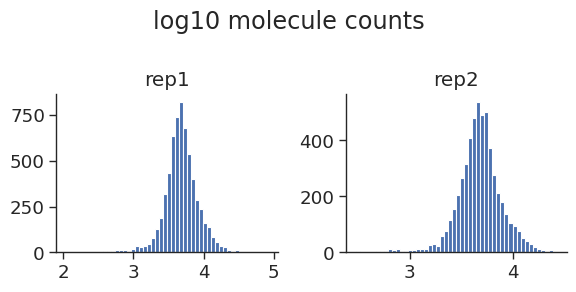

In [13]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs["total_counts"][sample_cells[sample]]), 50)
    ax.set_title(sample)
plt.suptitle("log10 molecule counts")
plt.tight_layout()
plt.show()

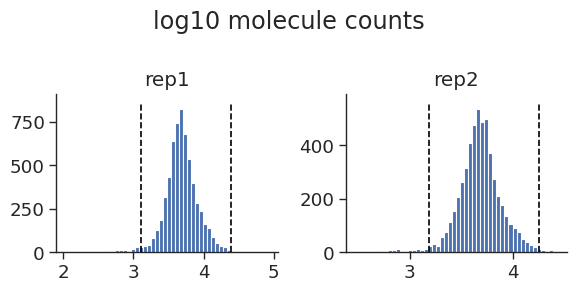

In [14]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    THRESHOLDS = np.log10(np.percentile((rna_ad.obs["total_counts"]), [2.5, 99.5]))
    ax.hist(np.log10(rna_ad.obs["total_counts"][sample_cells[sample]]), 50)
    ax.vlines(
        THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color="black", linestyle="--"
    )
    ax.set_title(sample)
plt.suptitle("log10 molecule counts")
plt.tight_layout()
plt.show()

In [15]:
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    cells = sample_cells[sample]

    # Filter
    THRESHOLDS = np.percentile((rna_ad.obs["total_counts"]), [2.5, 99.5])
    sample_cells[sample] = cells[
        (rna_ad.obs["total_counts"][cells] > THRESHOLDS[0])
        & (rna_ad.obs["total_counts"][cells] < THRESHOLDS[1])
    ]

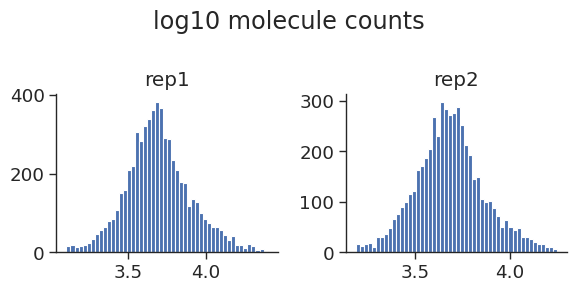

In [16]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs["total_counts"][sample_cells[sample]]), 50)
    ax.set_title(sample)
plt.suptitle("log10 molecule counts")
plt.tight_layout()
plt.show()

### Filtering based on ATAC

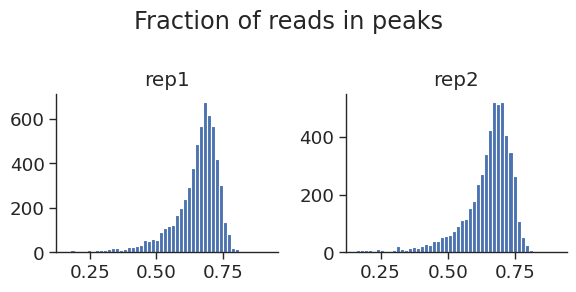

In [17]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    ax.hist(bc_metrics_dict[sample]["FRIP"][sample_cells[sample]], 50)
    ax.set_title(sample)
plt.suptitle("Fraction of reads in peaks")
plt.tight_layout()
plt.show()

In [18]:
# Given the uneven distribution, we will skip filtering by ATAC here.
THRESHOLD = 00
for sample in samples:
    sample_cells[sample] = sample_cells[sample][
        bc_metrics_dict[sample]["FRIP"][sample_cells[sample]] > THRESHOLD
    ]

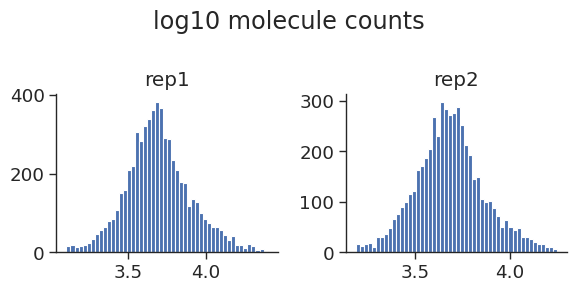

In [19]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs["total_counts"][sample_cells[sample]]), 50)
    ax.set_title(sample)
plt.suptitle("log10 molecule counts")
plt.tight_layout()
plt.show()

### Filter based on mitochondria

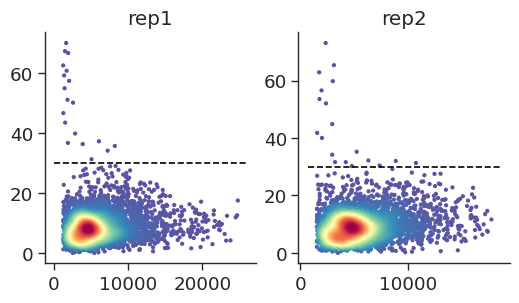

In [20]:
# Mitochondrial fractions compared to total molecules (colored by density)
MITO_THRESHOLD = 30
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]

    # Density
    x, y, dens = palantir.plot.density_2d(
        rna_ad.obs["total_counts"][sample_cells[sample]],
        rna_ad.obs["pct_counts_mt"][sample_cells[sample]],
    )

    ax.scatter(x, y, c=dens, s=5)
    ax.hlines(
        MITO_THRESHOLD,
        ax.get_xlim()[0],
        ax.get_xlim()[1],
        color="black",
        linestyle="--",
    )
    ax.set_title(sample)
plt.show()

In [21]:
for sample in samples:
    cells = sample_cells[sample]
    sample_cells[sample] = cells[
        rna_ad_dict[sample].obs["pct_counts_mt"][cells] < MITO_THRESHOLD
    ]

## Combine samples 

In [22]:
ad = anndata.concat(
    rna_ad_dict.values(), index_unique=None, keys=rna_ad_dict.keys(), merge="same"
)
selected_cells = set().union(*[set(cells) for cells in sample_cells.values()])
ad = ad[ad.obs_names.isin(selected_cells), :].copy()
ad.var["gene_id"] = ad.var_names
ad.var = ad.var.set_index("gene_name")
ad.var_names_make_unique()

In [23]:
# Filter cells
sc.pp.filter_genes(ad, min_cells=50)

In [24]:
ad

AnnData object with n_obs × n_vars = 11352 × 17351
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'feature_types', 'genome', 'chromosome', 'start', 'end', 'mt', 'gene_id', 'n_cells'

In [25]:
raw_ad = ad.copy()

### Doublet scores  (post filtering)

In [26]:
doublet_scores = pd.Series(0.0, index=ad.obs_names)

for sample in samples:
    cells = ad.obs_names[ad.obs["sample"] == sample]
    scrub = scr.Scrublet(raw_ad[cells, :].X)
    scores, predicted_doublets = scrub.scrub_doublets()
    doublet_scores[cells] = scores

ad.obs["DoubletScores"] = doublet_scores.values

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 35.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.1%
Elapsed time: 6.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 46.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.5%
Elapsed time: 4.9 seconds


## Analysis

In [27]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [28]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor="cell_ranger", n_top_genes=1500)
ad

AnnData object with n_obs × n_vars = 11352 × 17351
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'DoubletScores', 'n_counts'
    var: 'feature_types', 'genome', 'chromosome', 'start', 'end', 'mt', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [29]:
# PCA
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance
n_comps = 50
sc.pp.pca(ad, use_highly_variable=True, n_comps=n_comps)

In [30]:
sc.pp.neighbors(ad, use_rep="X_pca")
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

AnnData object with n_obs × n_vars = 11352 × 17351
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'DoubletScores', 'n_counts', 'leiden'
    var: 'feature_types', 'genome', 'chromosome', 'start', 'end', 'mt', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [31]:
# Diffusion maps
dm_res = palantir.utils.run_diffusion_maps(ad)
ad

AnnData object with n_obs × n_vars = 11352 × 17351
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'DoubletScores', 'n_counts', 'leiden'
    var: 'feature_types', 'genome', 'chromosome', 'start', 'end', 'mt', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DM_EigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel', 'DM_Similarity'

In [32]:
# Force directed layout
ad.obsm["X_FDL"] = harmony.plot.force_directed_layout(dm_res["kernel"]).values

100%|██████████| 500/500 [01:39<00:00,  5.05it/s]

BarnesHut Approximation  took  51.00  seconds
Repulsion forces  took  43.28  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  1.96  seconds
AdjustSpeedAndApplyForces step  took  1.09  seconds


In [33]:
ad.layers["MAGIC_imputed_data"] = impute_data(dm_res, ad)

# Visualize results

In [34]:
ad.obs["log_n_counts"] = np.log10(ad.obs["total_counts"])

Note that in the sample the two samples coincide very clearly indicating that there is no batch effect. This is completely expected since the two replicates were generated using cells from the same individual. Separation of cells based on sample here is a good diagnostic for batch effects

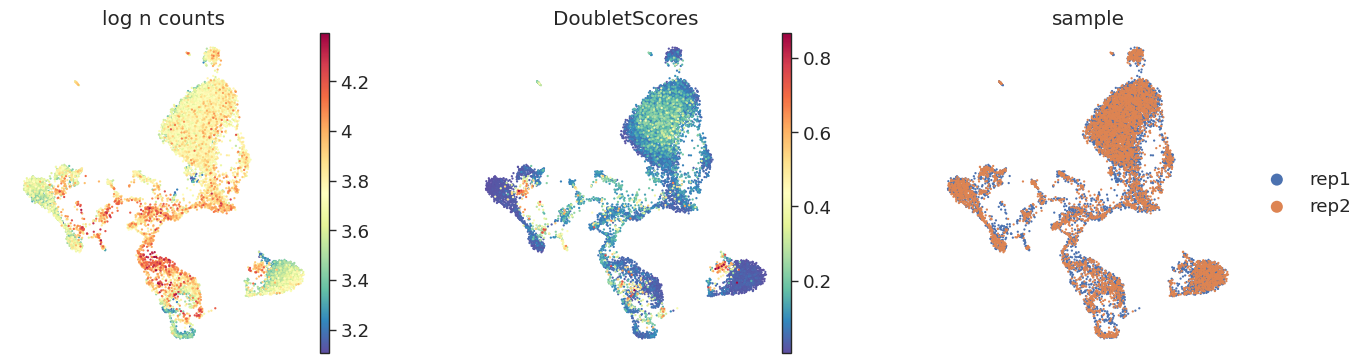

In [35]:
sc.pl.scatter(
    ad, basis="umap", color=["log_n_counts", "DoubletScores", "sample"], frameon=False
)

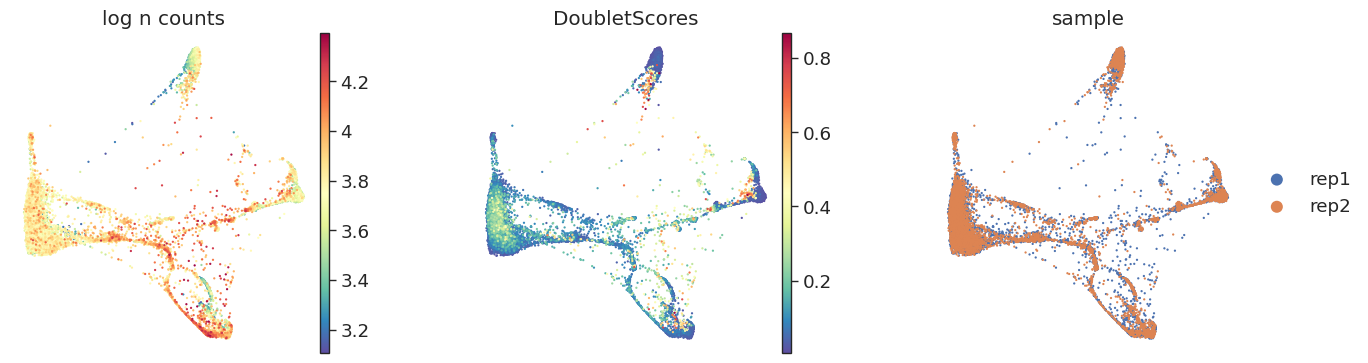

In [36]:
sc.pl.scatter(
    ad, basis="FDL", color=["log_n_counts", "DoubletScores", "sample"], frameon=False
)

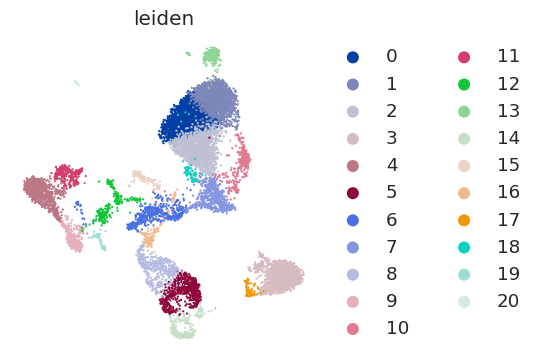

In [37]:
sc.pl.scatter(ad, basis="umap", color=["leiden"], frameon=False)

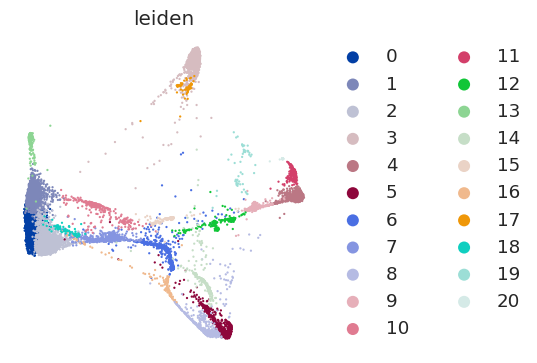

In [38]:
sc.pl.scatter(ad, basis="FDL", color=["leiden"], frameon=False)

# Celltype annotation

In [39]:
marker_dict = {
    "HSPC": ["CD34"],
    "CLP/Bcells": ["CD79B", "EBF1", "PAX5"],
    "B cells": ["CD19"],
    "Ery": ["GATA1", "GATA2"],
    "DC": ["IRF4", "IRF8"],
    "Mono": ["MPO"],
    "Megakaryocyte": ["ITGA2B"],
}

categories: 0, 1, 2, etc.
var_group_labels: HSPC, CLP/Bcells, B cells, etc.


/fh/fast/setty_m/user/dotto/mamba/envs/singlecell_test6/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


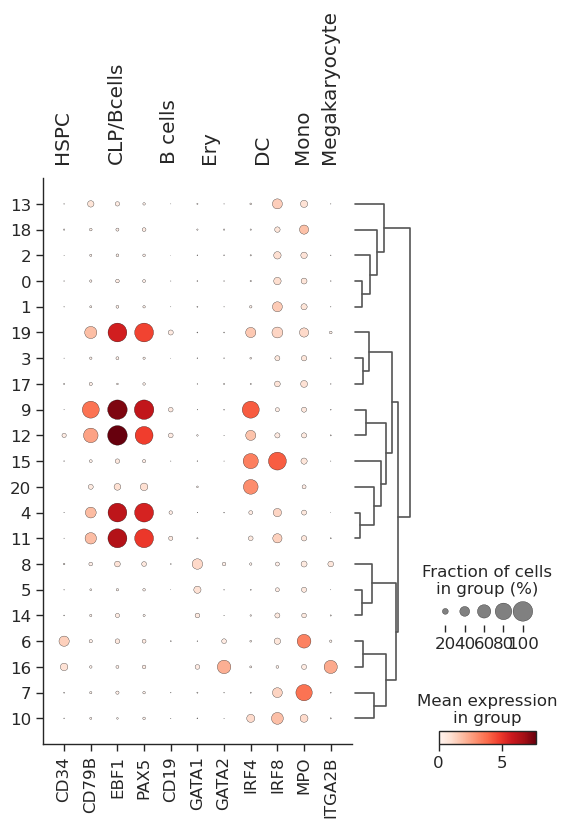

In [40]:
sc.pl.dotplot(ad, marker_dict, "leiden", dendrogram=True)

In [41]:
genes = pd.Series(
    [
        "CD34", "CD38",  # HSPC
        "CD79B", "EBF1", "PAX5",  # CLP / B cell lineage
        "CD19", "CD20",  # Mature B cell markers
        "GATA1",  # Erythroid lineage
        "IRF8",  # DC lineage
        "MPO",  # Monocyte lineage
        "ITGA2B",  # CD41 - Megakaryocyte,
    ]
)
genes = genes[genes.isin(ad.var_names)]

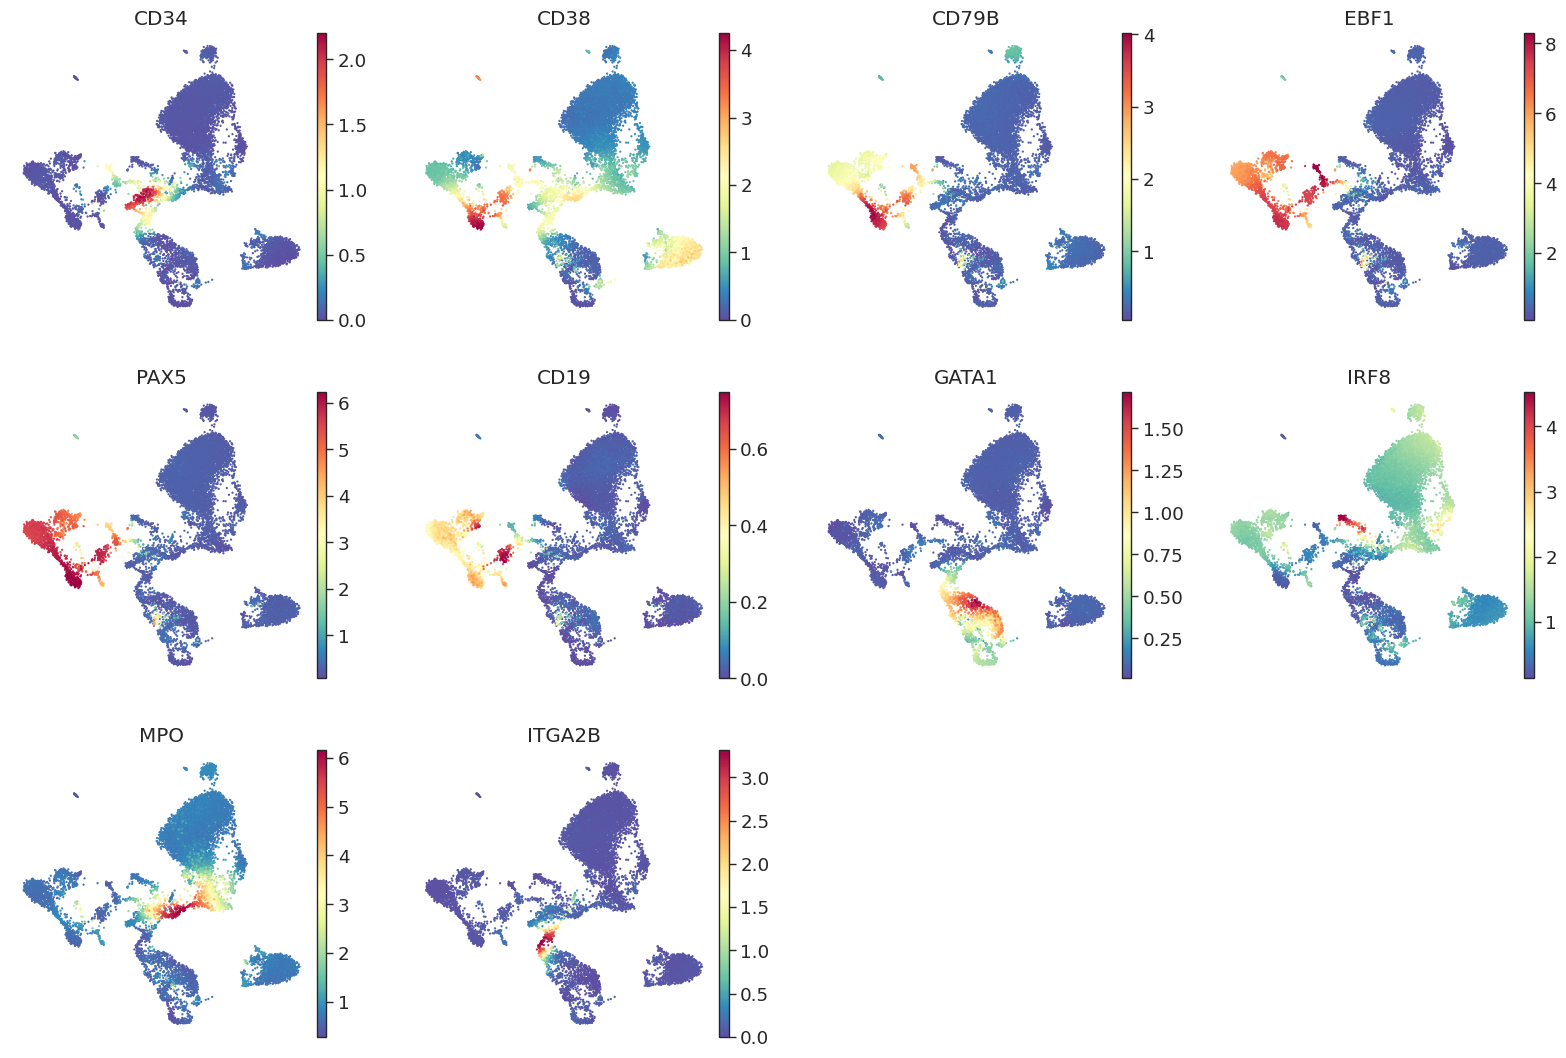

In [42]:
sc.pl.embedding(
    ad, basis="umap", color=genes, layer="MAGIC_imputed_data", frameon=False
)

# Save

In [43]:
# Attach raw counts
ad.raw = raw_ad

In [44]:
ad.write(os.path.join(output_dir, "combined_rna_anndata.h5ad"))

In [45]:
# Export cell names for ATAC - only this subset of cells will be use for ATAC analysis
pd.DataFrame(ad.obs_names).to_csv(os.path.join(output_dir, "filtered_cells.csv"))

In [46]:
output_dir

'multi-sample-multiome'

In [47]:
!ls -ltrh $output_dir

total 4.1G
-rw-rw---- 1 dotto setty_m_grp 1.2M Oct  2  2022 rep1w
-rw-rw---- 1 dotto setty_m_grp 3.0M Jan 11  2023 features.tsv.gz
drwxrws--- 2 dotto setty_m_grp  170 Dec 20 13:07 rep2
drwxrws--- 2 dotto setty_m_grp  170 Dec 20 13:07 rep1
-rw-rw---- 1 dotto setty_m_grp 1.7G Dec 20 13:10 bm_multiome_rna.h5ad
-rw-rw---- 1 dotto setty_m_grp 441K Dec 20 13:10 bm_multiome_cells.csv
-rw-rw---- 1 dotto setty_m_grp 1.8G Dec 28 13:50 combined_rna_anndata.h5ad
-rw-rw---- 1 dotto setty_m_grp 322K Dec 28 13:50 filtered_cells.csv


In [48]:
user_info = pwd.getpwuid(os.getuid())
author = user_info.pw_gecos
email = user_info.pw_name + "@fredhutch.org"
%load_ext watermark
%watermark -a "{author}" -e {email} -h -v -iv -m -u -w -i

Author: Dominik Otto, S2-106, x4475,umask=0007, Setty Lab,

Email: dotto@fredhutch.org

Last updated: 2023-12-28T13:50:02.039769-08:00

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.13.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 4.15.0-213-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 36
Architecture: 64bit

Hostname: gizmok68

scrublet  : 0.2.3
pandas    : 1.5.3
numpy     : 1.23.5
palantir  : 1.2
anndata   : 0.9.1
scanpy    : 1.9.3
harmony   : 0.1.4
matplotlib: 3.7.1

Watermark: 2.4.3

